In [39]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import json
from itertools import chain
import multiprocessing
from collections import defaultdict

# Data Cleaning/EDA

First dataframe - each column is an individual user. This is the main dataframe we will work off of.

In [40]:
df_peeps = pd.read_json('radiate_peeps.json')

In [41]:
df_peeps.set_index('pk', inplace=True)

In [92]:
df_peeps.head()

,birthday,crush_ratio,gender,has_instagram,last_login,matches,peep_bubbles__count,tagline,age,age_in_days,iphone_user,has_bio,avg_num_msgs,num_matches,pct_logins_wknd,Q1_pct,Q2_pct,Q3_pct,Q4_pct,churn
pk,,,,,,,,,,,,,,,,,,,,
263742,1997-09-21,0.772937,1,0,2017-12-25 21:22:11.543180,[{u'created_on': u'2017-08-27T18:11:21.556813+...,19,🤷🏼‍♀️,20.0,7442,0,1,2,0.0,0.086400,0.068800,0.006400,0.392000,0.532800,0
260988,1986-04-09,0.237527,0,0,2018-01-18 06:07:33.574752,[{u'created_on': u'2017-10-22T03:56:35.656612+...,15,,31.0,11625,0,0,3,0.0,0.227566,0.084709,0.180187,0.222541,0.512563,0
244211,1994-09-27,0.794365,1,1,2018-01-22 17:09:54.480483,[{u'created_on': u'2018-01-19T21:44:25.739253+...,17,🍄🐢,23.0,8532,0,1,6,0.0,0.293893,0.024809,0.150763,0.437023,0.387405,0
256286,1996-10-23,0.321168,0,0,2018-01-14 23:05:18.539342,[{u'created_on': u'2016-10-06T02:21:14.432229+...,47,From Sac town! \nAll about the bass😝 \nSc:tguM...,21.0,7775,1,1,1,0.0,0.194379,0.175644,0.296253,0.199063,0.329040,0
247662,1992-11-23,0.230469,0,0,2018-01-21 01:08:56.720441,[{u'created_on': u'2017-12-29T16:30:28.929724+...,6,,25.0,9205,1,0,4,0.0,0.275547,0.084854,0.065693,0.497263,0.352190,0


In [43]:
df_peeps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143302 entries, 263742 to 306280
Data columns (total 12 columns):
android_api_level      22972 non-null float64
birthday               143302 non-null object
country                100464 non-null object
crush_ratio            143302 non-null float64
gender                 143302 non-null object
has_instagram          143302 non-null bool
ios_system_version     88708 non-null object
last_location          121891 non-null object
last_login             143302 non-null object
matches                143302 non-null object
peep_bubbles__count    143302 non-null int64
tagline                143302 non-null object
dtypes: bool(1), float64(2), int64(1), object(8)
memory usage: 13.3+ MB


In [44]:
df_peeps['last_login'] = pd.to_datetime(df_peeps['last_login'])

In [45]:
# Feature Engineering - create age feature

def calculate_age(bday):
    today = dt.date.today()
    return today.year - bday.year - ((today.month, today.day) < (bday.month, bday.day))

df_peeps['birthday'].replace('1349-12-17', np.nan, inplace=True)
df_peeps['birthday'] = pd.to_datetime(df_peeps['birthday'])
df_peeps['age'] = df_peeps['birthday'].apply(calculate_age)
df_peeps.dropna(subset=['age'], inplace=True)

In [46]:
def calculate_age_in_days(bday):
    today = dt.date.today()
    age = today - bday.date()
    return age.days

df_peeps['age_in_days'] = df_peeps['birthday'].apply(calculate_age_in_days)

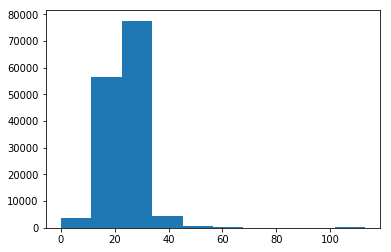

In [47]:
plt.hist(df_peeps['age'])
plt.show()

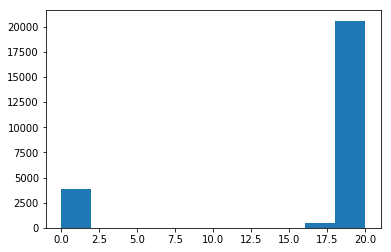

In [48]:
plt.hist(df_peeps['age'], range=(0,20))
plt.show()

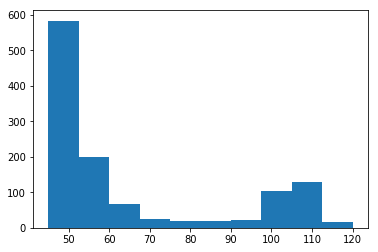

In [49]:
plt.hist(df_peeps['age'], range=(45,120))
plt.show()

The two histograms above show user spikes at age <2 and >90 which is likely erroneous, so we will remove these observations from the dataset.

In [50]:
df_peeps = df_peeps[(df_peeps['age']>1) & (df_peeps['age']<90)]

In [51]:
# Convert binary columns to 0's and 1's

df_peeps['gender'] = df_peeps['gender'].replace({'m':0,'f':1}) #0 means male
df_peeps['has_instagram'] = df_peeps['has_instagram'].map({True:1, False:0})
df_peeps['iphone_user'] = pd.isnull(df_peeps['android_api_level']).map({True: 1, False: 0})

df_peeps.drop(['ios_system_version','android_api_level'], axis=1, inplace=True)

In [52]:
# drop country and last_location (we will look at location data in a cleaner way later)

df_peeps.drop(['country', 'last_location'], axis=1, inplace=True)

In [53]:
# Feature enginnering - create bio columns

df_peeps['has_bio'] = df_peeps['tagline'].apply(lambda x: 0 if x=='' else 1)

In [54]:
# Feature engineering - create avg num messages column

def avg_num_msgs(row):
    sum_msgs = 0
    for d in row:
        sum_msgs += d['num_privatemessages']
        
    total_matches = len(row)
    if total_matches==0:
        return 0
    else:
        return sum_msgs/total_matches
    
df_peeps['avg_num_msgs'] = df_peeps['matches'].apply(avg_num_msgs)

In [55]:
# need to remove all matches with "Rad the Rhino", a robot who is matched with all users 

def remove_rad_match(row):
    return row[1:]

df_peeps['matches'] = df_peeps['matches'].apply(remove_rad_match)

In [56]:
# Feature engineering - create num matches column

df_peeps['num_matches'] = pd.Series([len(i) for i in df_peeps['matches']])
df_peeps['num_matches'].fillna(0, inplace=True)

df_peeps.drop('matches', axis=1, inplace=True)

# Logins Dataframe

In [57]:
df_logins = pd.read_csv('radiate_logins.csv', usecols=[1,2], parse_dates=['login'])

In [76]:
df_logins.head()

,pk,login,weekend,weekday,qtr,year,qtr_yr,_Q1-2016,_Q1-2017,_Q2-2016,_Q2-2017,_Q3-2016,_Q3-2017,_Q4-2016,_Q4-2017
0,263742,2017-12-25 21:22:11.523082,0,1,Q4,2017,Q4-2017,0,0,0,0,0,0,0,1
1,263742,2017-12-25 21:10:39.479529,0,1,Q4,2017,Q4-2017,0,0,0,0,0,0,0,1
2,263742,2017-12-25 04:02:56.129357,0,1,Q4,2017,Q4-2017,0,0,0,0,0,0,0,1
3,263742,2017-12-25 04:02:23.743966,0,1,Q4,2017,Q4-2017,0,0,0,0,0,0,0,1
4,263742,2017-12-25 03:58:38.612911,0,1,Q4,2017,Q4-2017,0,0,0,0,0,0,0,1


In [59]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34549450 entries, 0 to 34549449
Data columns (total 2 columns):
pk       int64
login    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 527.2 MB


In [60]:
df_logins['weekend'] = np.where(df_logins['login'].dt.weekday>=5, 1, 0) #sat and sun
df_logins['weekday'] = np.where(df_logins['login'].dt.weekday<5, 1, 0)

# 0 is Monday and 6 is Sunday

In [61]:
def calendar_qtr(row):
    doy = row.timetuple().tm_yday
    if doy in range(0, 92):
        return 'Q1'
    elif doy in range(92, 183):
        return 'Q2'
    elif doy in range(183, 274):
        return 'Q3'
    else:
        return 'Q4'

In [62]:
df_logins['qtr'] = df_logins['login'].apply(calendar_qtr)

In [63]:
df_logins['year'] = df_logins['login'].dt.year

In [64]:
# Exclude 2015 and 2018 since we don't have full years

df_logins = df_logins[(df_logins['year']==2016) | (df_logins['year']==2017)]

In [65]:
# Create qtr+year column

df_logins['qtr_yr'] = df_logins['qtr'] + '-' + df_logins['year'].map(str)

In [66]:
# Create dummies for qtr_yr and merge with 

qtr_yr_dum = pd.get_dummies(df_logins['qtr_yr'], prefix='')
df_logins = pd.concat([df_logins, qtr_yr_dum], axis=1)

# del qtr_yr_dum

In [67]:
# df_logins = pd.read_pickle('df_logins.pkl')

In [68]:
# 'groupby' the logins dataframe so we can analyze logins per user

df_logins_groupby = df_logins.groupby('pk').sum()

In [69]:
df_logins_groupby.head()

,weekend,weekday,year,_Q1-2016,_Q1-2017,_Q2-2016,_Q2-2017,_Q3-2016,_Q3-2017,_Q4-2016,_Q4-2017
pk,,,,,,,,,,,
200016,8660,21326,60464982,7603.0,1450.0,4584.0,8386.0,3345.0,1375.0,1248.0,1995.0
200017,10587,32935,87761354,6151.0,5398.0,7090.0,7312.0,5503.0,3821.0,3776.0,4471.0
200019,6,12,36288,9.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
200020,55,87,286297,65.0,9.0,12.0,1.0,16.0,9.0,24.0,6.0
200029,28,159,377054,43.0,26.0,46.0,28.0,22.0,7.0,14.0,1.0


In [70]:
# Feature engineering - create weekday/weekend and calendar quarter percent columns

df_logins_groupby['total'] = df_logins_groupby['weekend']+df_logins_groupby['weekday']

df_logins_groupby['pct_logins_wknd'] = df_logins_groupby['weekend']/df_logins_groupby['total']

df_logins_groupby['Q1_pct'] = (df_logins_groupby['_Q1-2016']+df_logins_groupby['_Q1-2017'])/df_logins_groupby['total']
df_logins_groupby['Q2_pct'] = (df_logins_groupby['_Q2-2016']+df_logins_groupby['_Q2-2017'])/df_logins_groupby['total']
df_logins_groupby['Q3_pct'] = (df_logins_groupby['_Q3-2016']+df_logins_groupby['_Q3-2017'])/df_logins_groupby['total']
df_logins_groupby['Q4_pct'] = (df_logins_groupby['_Q4-2016']+df_logins_groupby['_Q4-2017'])/df_logins_groupby['total']

Note: I have included all quarters for now to make interpretation easier in EDA but I will drop Q1 later on to make it the baseline before running models

Because music festivals are seasonal (more popular in late Spring, Summer, and early Fall), we want to analyze the data on a year-over-year basis. First, we define quarterly churn for each user. A value of 1 means that this user logged in in a particular calendar quarter last year, but not this year. 

The binary churn metric we will use is, if a user churned in any particular calendar quarter, they are considered a churn user.

In [71]:
def quarterly_churn(row16,row17):
    if int(row16)>0 and int(row17)==0:
        return 1
    else:
        return 0

In [72]:
for q in ['_Q1','_Q2','_Q3','_Q4']:
    col_16 = q+'-2016'
    col_17 = q+'-2017'
    churn = q[1:]+'_churn'
    df_logins_groupby[churn] = df_logins_groupby.apply(lambda x: quarterly_churn(x[col_16], x[col_17]),axis=1)

In [73]:
df_logins_groupby = df_logins_groupby[(df_logins_groupby['_Q1-2016']>0) |
                                      (df_logins_groupby['_Q2-2016']>0) |
                                      (df_logins_groupby['_Q3-2016']>0) |
                                      (df_logins_groupby['_Q4-2016']>0) ]

We will only look at users who we have data from 2016 for since we are using a year-over-year churn definition from 2016 to 2017.

In [74]:
df_logins_groupby['churn'] = np.where((df_logins_groupby['Q1_churn']>0)|
                                      (df_logins_groupby['Q2_churn']>0)|
                                      (df_logins_groupby['Q3_churn']>0)|
                                      (df_logins_groupby['Q4_churn']>0), 1, 0)

In [75]:
# Merge with df_peeps (by-user dataframe)

df_peeps = df_peeps.merge(df_logins_groupby[['pct_logins_wknd','Q1_pct','Q2_pct','Q3_pct','Q4_pct','churn']], left_index=True, right_index=True)
del df_logins_groupby

# Bubbles

In [93]:
df_bubbles = pd.read_json('radiate_bubbles.json', convert_dates=['date_start','date_end'])

In [94]:
df_bubbles = df_bubbles.set_index('bubble_id')

In [95]:
df_bubbles.head()

,address,date_end,date_start,display_name
bubble_id,,,,
205,"Todd Mission, TX",2017-05-07,2017-05-05,Middlelands
179,"Nos Events Center, CA",2017-11-25,2017-11-24,Dreamstate
46,"San Bernardino, CA",2017-09-16,2017-09-15,Nocturnal Wonderland
278,"Oklahoma City, OK",2017-08-19,2017-08-19,DayDream
54,"Atlantic City, NJ",2016-08-02,2016-08-01,Electric Adventure


In [96]:
df_bubbles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 205 to 224
Data columns (total 4 columns):
address         217 non-null object
date_end        217 non-null datetime64[ns]
date_start      217 non-null datetime64[ns]
display_name    217 non-null object
dtypes: datetime64[ns](2), object(2)
memory usage: 8.5+ KB


In [97]:
def get_loc(row):
    ix = row.find(',')
    return row[ix+2:].upper()

df_bubbles['festival_loc'] = df_bubbles['address'].apply(get_loc)

In [98]:
df_bubbles.replace({
    'CALIFORNIA':'CA',
    'OREGON':'OR',
    'MICHIGAN':'MI',
    'WEST VIRGINIA':'WV',
    'OHIO':'OH',
    'ARIZONA':'AZ',
    'VIRGINIA':'VA',
    'TEXAS':'TX',
    'FLORIDA':'FL',
    'CHICAGO, MICHIGAN':'IL', #just calling this IL
    'DELAWARE':'DE',
    'NITED KINGDOM':'UNITED KINGDOM',
    'UK':'UNITED KINGDOM',
    '.C. / BALTIMORE':'MD',
    'ITI FIELD':'NY',
    'ON':'CANADA'
}, inplace=True)

In [99]:
df_bubbles['festival_loc'].value_counts().head()

# location counts have a long tail so I'm going to group them into 
# census regions to get more of an idea of general trends

CA        38
FL        18
TX        17
NY        16
CANADA    12
Name: festival_loc, dtype: int64

In [100]:
census = pd.read_csv('census_divisions.csv')

In [101]:
census.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [102]:
df_bubbles = df_bubbles.merge(census, how ='left', left_on='festival_loc', right_on='State Code')
df_bubbles.drop(['State', 'State Code', 'Region'], axis=1, inplace=True)

In [103]:
df_bubbles.rename(columns={'Division':'Region'}, inplace=True)

In [104]:
# Inspect Non-US festivals

df_bubbles[df_bubbles['Region'].isnull()]['festival_loc'].value_counts()

CANADA            12
UNITED KINGDOM     4
FRANCE             4
BELGIUM            2
GERMANY            2
MEXICO             2
NETHERLANDS        2
HUNGARY            1
CROATIA            1
IRELAND            1
INDIA              1
ICELAND            1
WHENEVER           1
ROMANIA            1
Name: festival_loc, dtype: int64

In [105]:
df_bubbles.loc[df_bubbles['festival_loc']=='CANADA', 'Region'] = 'Canada'
df_bubbles.loc[df_bubbles['festival_loc']=='MEXICO', 'Region'] = 'Mexico'
df_bubbles.loc[(df_bubbles['festival_loc']=='INDIA')|(df_bubbles['festival_loc']=='WHEREVER'), 'Region'] = 'Misc'
df_bubbles['Region'].fillna('Europe', inplace=True)

In [106]:
region_dum = pd.get_dummies(df_bubbles['Region'], prefix='festival_region')
df_bubbles = pd.concat([df_bubbles, region_dum], axis=1)
del region_dum

In [107]:
df_bubbles['qtr'] = df_bubbles['date_start'].apply(calendar_qtr)
qtr_dums = pd.get_dummies(df_bubbles['qtr'])
df_bubbles = pd.concat([df_bubbles, qtr_dums],axis=1)

df_bubbles.drop('qtr', axis=1, inplace=True)
del qtr_dums

In [108]:
# Feature Engineering - create avg festival length feature
df_bubbles['festival_length'] = (df_bubbles['date_end'] - df_bubbles['date_start']).dt.days

# Peep Bubbles

Each row in this dataframe is for a specific bubble/user combination, so we have bubble and user-specific info

In [109]:
df_peep_bubbles = pd.read_csv('radiate_peep_bubbles.csv', usecols=[1,3,4])

In [110]:
# merge bubbles with peep bubbles so we can get peep-specific info to later merge w/ main df
df_peep_bubbles = df_peep_bubbles.merge(df_bubbles, left_on='bubble_id', right_index=True)

In [111]:
df_peep_bubbles.head()

,bubble_id,joined_status,pk,address,date_end,date_start,display_name,festival_loc,Region,festival_region_Canada,...,festival_region_New England,festival_region_Pacific,festival_region_South Atlantic,festival_region_West North Central,festival_region_West South Central,Q1,Q2,Q3,Q4,festival_length
0,23,NO,263742,"Mountain View, CA",2017-07-15,2017-07-15,Audiotistic,CA,Pacific,0,...,0,1,0,0,0,0,0,1,0,0
69,23,YES,292558,"Mountain View, CA",2017-07-15,2017-07-15,Audiotistic,CA,Pacific,0,...,0,1,0,0,0,0,0,1,0,0
83,23,YES,328806,"Mountain View, CA",2017-07-15,2017-07-15,Audiotistic,CA,Pacific,0,...,0,1,0,0,0,0,0,1,0,0
103,23,YES,283681,"Mountain View, CA",2017-07-15,2017-07-15,Audiotistic,CA,Pacific,0,...,0,1,0,0,0,0,0,1,0,0
108,23,YES,339394,"Mountain View, CA",2017-07-15,2017-07-15,Audiotistic,CA,Pacific,0,...,0,1,0,0,0,0,0,1,0,0


In [112]:
join_dums = pd.get_dummies(df_peep_bubbles['joined_status'], prefix='joined')
df_peep_bubbles = pd.concat([df_peep_bubbles, join_dums], axis=1).drop('joined_status', axis=1)

del join_dums

In [113]:
df_peep_bubbles_groupby = df_peep_bubbles.groupby('pk').sum()

In [114]:
df_peep_bubbles_groupby = df_peep_bubbles.groupby('pk').sum()
df_fest_len = df_peep_bubbles.groupby('pk')['festival_length'].mean().to_frame()

In [115]:
# Feature Engineering - Create Avg Festival Length feature

df_peep_bubbles_groupby = df_peep_bubbles.groupby('pk').sum()
df_fest_len = df_peep_bubbles.groupby('pk')['festival_length'].mean().to_frame()
df_fest_len.rename(columns={'festival_length':'avg_festival_length'}, inplace=True)

df_peep_bubbles_groupby = df_peep_bubbles_groupby.merge(df_fest_len, left_index=True, right_index=True)
df_peep_bubbles.drop('festival_length', axis=1, inplace=True)

In [116]:
# Feature Engineering - percent of peeps left

df_peep_bubbles_groupby['total'] = df_peep_bubbles_groupby[['joined_MAYBE','joined_YES','joined_NO']].sum(axis=1)
df_peep_bubbles_groupby['pct_peeps_left'] = 1.*df_peep_bubbles_groupby['joined_NO']/df_peep_bubbles_groupby['total']

In [117]:
df_peep_bubbles_groupby.head()

,bubble_id,festival_region_Canada,festival_region_East North Central,festival_region_East South Central,festival_region_Europe,festival_region_Mexico,festival_region_Middle Atlantic,festival_region_Misc,festival_region_Mountain,festival_region_New England,...,Q2,Q3,Q4,festival_length,joined_MAYBE,joined_NO,joined_YES,avg_festival_length,total,pct_peeps_left
pk,,,,,,,,,,,,,,,,,,,,,
200016,9892,4,7,2,11,0,10,1,11,1,...,31,38,26,195,22,39,46,1.822430,107,0.364486
200017,20884,7,15,2,18,2,21,1,20,4,...,38,74,45,324,5,38,134,1.830508,177,0.214689
200019,1293,0,3,1,1,0,3,0,2,0,...,7,7,4,37,1,0,18,1.947368,19,0.000000
200020,3079,2,3,2,7,1,4,1,4,1,...,16,18,9,97,5,0,45,1.940000,50,0.000000
200029,1295,1,2,0,1,0,1,1,3,0,...,7,5,7,43,1,0,22,1.869565,23,0.000000


In [118]:
# Merge with user dataframe
df_peeps = df_peeps.merge(df_peep_bubbles_groupby.drop(['Q1','Q2','Q3','Q4','joined_MAYBE','joined_YES','joined_NO','total'],axis=1), left_index=True, right_index=True)

# del df_peep_bubbles_groupby

# More EDA

In [119]:
df_peeps.head()

,birthday,crush_ratio,gender,has_instagram,last_login,matches,peep_bubbles__count,tagline,age,age_in_days,...,festival_region_Misc,festival_region_Mountain,festival_region_New England,festival_region_Pacific,festival_region_South Atlantic,festival_region_West North Central,festival_region_West South Central,festival_length,avg_festival_length,pct_peeps_left
pk,,,,,,,,,,,,,,,,,,,,,
263742,1997-09-21,0.772937,1,0,2017-12-25 21:22:11.543180,[{u'created_on': u'2017-08-27T18:11:21.556813+...,19,🤷🏼‍♀️,20.0,7442,...,0,4,0,4,1,0,0,19,1.266667,0.800000
260988,1986-04-09,0.237527,0,0,2018-01-18 06:07:33.574752,[{u'created_on': u'2017-10-22T03:56:35.656612+...,15,,31.0,11625,...,0,1,0,4,4,0,1,29,2.071429,0.071429
244211,1994-09-27,0.794365,1,1,2018-01-22 17:09:54.480483,[{u'created_on': u'2018-01-19T21:44:25.739253+...,17,🍄🐢,23.0,8532,...,0,0,0,4,5,0,1,21,1.615385,0.000000
256286,1996-10-23,0.321168,0,0,2018-01-14 23:05:18.539342,[{u'created_on': u'2016-10-06T02:21:14.432229+...,47,From Sac town! \nAll about the bass😝 \nSc:tguM...,21.0,7775,...,1,4,1,6,8,0,3,60,1.578947,0.736842
247662,1992-11-23,0.230469,0,0,2018-01-21 01:08:56.720441,[{u'created_on': u'2017-12-29T16:30:28.929724+...,6,,25.0,9205,...,0,0,0,1,2,0,1,12,2.400000,0.000000


In [435]:
df_peeps.groupby('churn').mean().T

churn,0,1
crush_ratio,0.406027,0.382400
gender,0.312380,0.320486
has_instagram,0.220222,0.066810
peep_bubbles__count,13.650437,6.085745
pk,236937.039314,240433.349090
age,24.316429,24.773316
iphone_user,0.798104,0.538441
has_bio,0.724590,0.445243
avg_num_msgs,3.434797,2.192439
num_matches,14.748029,19.917545


In [268]:
# df_peeps.drop(['pct_logins_wknd_y','pct_logins_wkday'],axis=1,inplace=True)

In [70]:
'''
higher churn:
lower CR
lower gender
lower insta
higher peep_bubbles ct
older
not iphone user
less likely to have bio
shorter bio length
lower num msgs
less matches
more maybes
less no's
more yes's
less CA
more FL
more fall
more spring
more summer
less winter --> winter ppl are more devoted
less peeps left - ppl who go and update status are more involved w app
shorter festival length
more India
'''

"\nhigher churn:\nlower CR\nlower gender\nlower insta\nhigher peep_bubbles ct\nolder\nnot iphone user\nless likely to have bio\nshorter bio length\nlower num msgs\nless matches\nmore maybes\nless no's\nmore yes's\nless CA\nmore FL\nmore fall\nmore spring\nmore summer\nless winter --> winter ppl are more devoted\nless peeps left - ppl who go and update status are more involved w app\nshorter festival length\nmore India\n"

In [162]:
# df_peeps.describe().T

In [72]:
'''
out of total population...
more android users than iphone users
more men than women
'''

'\nout of total population...\nmore android users than iphone users\nmore men than women\n\n'

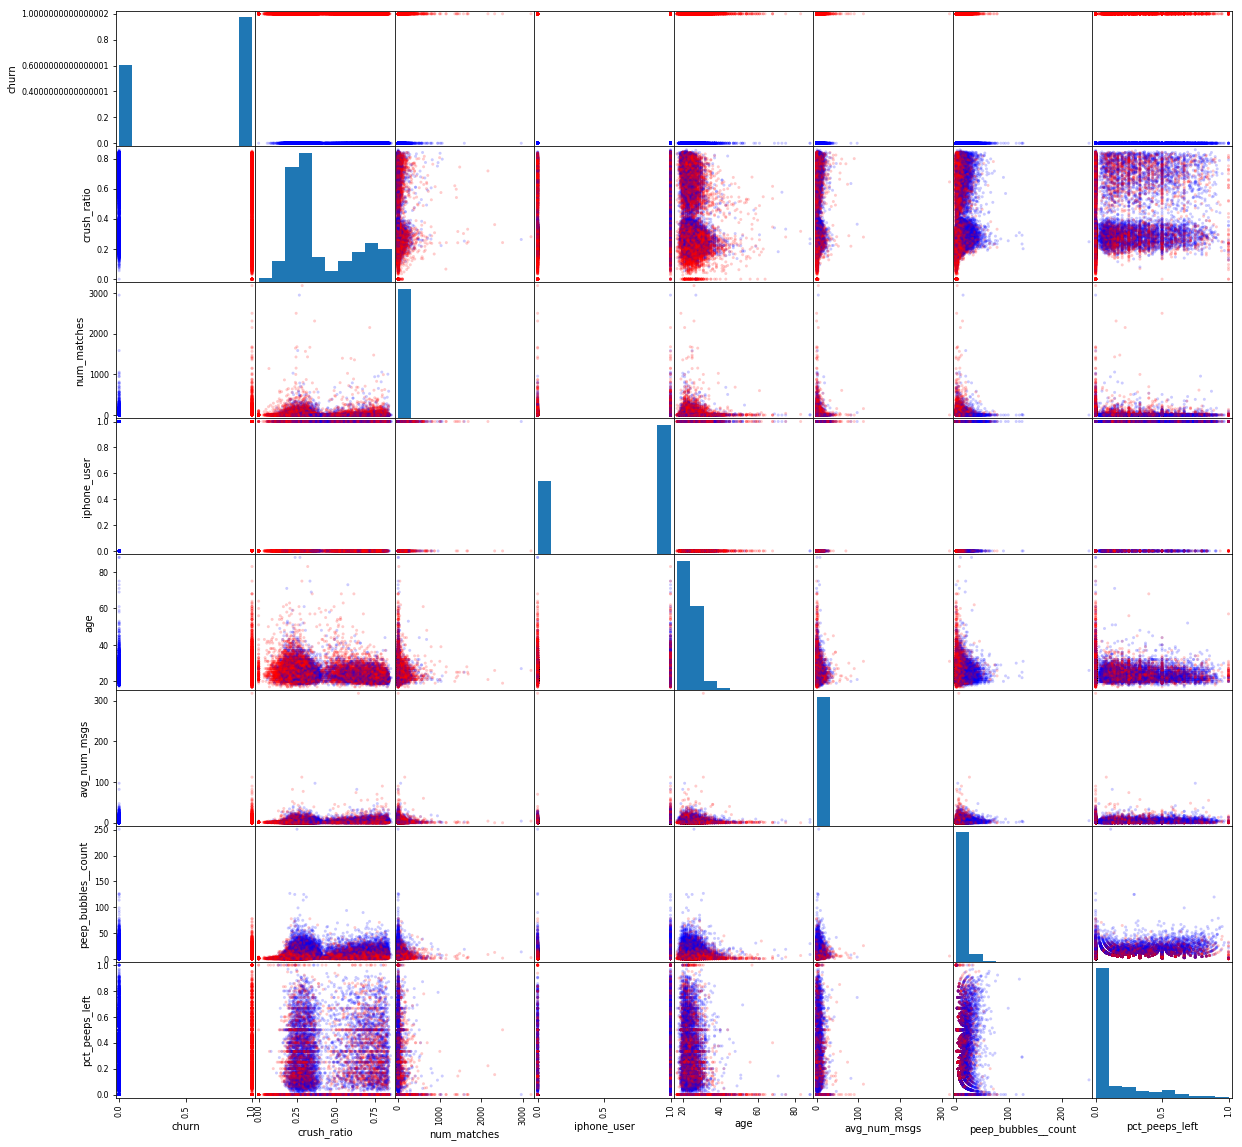

In [89]:
scatter_features = ['churn','crush_ratio', 'num_matches', 'iphone_user', 'age','avg_num_msgs','peep_bubbles__count','pct_peeps_left']
colors = ['red' if i else 'blue' for i in df_peeps['churn']]
# red means churn

scatter_matrix(df_peeps[scatter_features], alpha=0.2, figsize=(20, 20), diagonal='hist', color=colors)
plt.show()

In [ ]:
df_peeps['peep_bubbles__count'].describe()

In [ ]:
# scatter_features2 = df_cleaned[['pct_joined','peeps_joined','peep_bubbles__count', 'avg_bubble_joins']]
# colors = ['red' if i else 'blue' for i in df_peeps['churn_Dec']]
# # red means churn, blue is not churn

# scatter_matrix(scatter_features2, alpha=0.2, figsize=(20, 20), diagonal='hist', color=colors)
# plt.show()

In [45]:
'''
users who do not churn (blue)... 
higher peep bubbles count - going to more events
slightly higher crush ratio
'''

'\nusers who do not churn... \nhigher peep bubbles count - going to more events\nslightly higher crush ratio\n'

# Modeling

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import sklearn.metrics as skm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [145]:
y = df_peeps['churn']
X = df_peeps.drop(['churn','tagline','birthday', 'last_login','age',
                   'matches', 'num_matches', 'Q1_pct'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.20, random_state=67)

Dropping columns:
* churn - we should not include this in the model since this is what we are trying to predict!
* last_login - we used this to define churn, so definitely don't want to include
* age - we have age_in_days... we only used age for EDA purposes
* bubble_id - this is just an identifier for the actual festivals and we have coded the attributes of festivals in separate features
* tagline - this is text based and we used it for our topic modeling
* matches - we used this to create num_matches
* num_matches - highly correlated w/ other features

In [128]:
def run_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    print "Accuracy:", round(model.score(X_test, y_test),3)
    print "AUC:", round(skm.roc_auc_score(y_test, model.predict(X_test)),3)
    return

# Logistic Regression

In [123]:
logistic = LogisticRegression()

In [124]:
run_model(logistic, X_train, X_test, y_train, y_test)

Accuracy: 0.726
AUC 0.693


In [186]:
# for col, feat_imp in sorted(zip(X.columns, logistic.coef_[0]), key = lambda x:x[1], reverse=True):
#     print col, feat_imp

In [162]:
# logistic.coef_[0]

# SVM

In [125]:
svm_pipe = Pipeline([('scaler', StandardScaler()),
                        ('svc', SVC(kernel='rbf'))])
svm_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [127]:
run_model(svm_pipe, X_train, X_test, y_train, y_test)

Accuracy: 0.743
AUC 0.714


# Random Forest

In [146]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [147]:
run_model(rf, X_train, X_test, y_train, y_test)

Accuracy: 0.752
AUC: 0.746


In [148]:
for col, feat_imp in sorted(zip(X.columns, rf.feature_importances_), key = lambda x:x[1], reverse=True):
    print col, round(feat_imp, 3)

Q2_pct 0.109
peep_bubbles__count 0.095
bubble_id 0.073
Q3_pct 0.071
pct_logins_wknd 0.064
festival_length 0.064
Q4_pct 0.063
crush_ratio 0.06
age_in_days 0.057
pct_peeps_left 0.046
avg_num_msgs 0.045
avg_festival_length 0.043
festival_region_Pacific 0.033
iphone_user 0.025
festival_region_South Atlantic 0.024
festival_region_Middle Atlantic 0.018
festival_region_Mountain 0.016
has_instagram 0.014
festival_region_East North Central 0.014
festival_region_Europe 0.013
festival_region_West South Central 0.012
has_bio 0.011
festival_region_Canada 0.009
gender 0.007
festival_region_East South Central 0.005
festival_region_Misc 0.004
festival_region_New England 0.003
festival_region_West North Central 0.001
festival_region_Mexico 0.001


# Boosting

In [134]:
gbc = GradientBoostingClassifier()

In [136]:
run_model(gbc, X_train, X_test, y_train, y_test)

Accuracy: 0.774
AUC: 0.753


In [137]:
gbc_grid = {
    'learning_rate': [.01, .1, .5],
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [1, 3, 5],
    'n_estimators': [500, 1000],
    'subsample': [0.5, 0.75, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

In [138]:
gbc_grid_cv = GridSearchCV(GradientBoostingClassifier(), gbc_grid, n_jobs=-1, scoring='roc_auc')

In [139]:
gbc_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1, 0.5], 'min_samples_leaf': [1, 3, 5], 'n_estimators': [500, 1000], 'subsample': [0.5, 0.75, 1.0], 'max_features': ['sqrt', 'log2', None], 'max_depth': [2, 4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [140]:
best_model = gbc_grid_cv.best_estimator_
best_params = gbc_grid_cv.best_params_

In [141]:
best_params

{'learning_rate': 0.01,
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 3,
 'n_estimators': 1000,
 'subsample': 0.75}

In [142]:
gbc_grid_cv.best_score_

0.8494989510685621

In [144]:
for col, feat_imp in sorted(zip(X.columns, best_model.feature_importances_), key = lambda x:x[1], reverse=True):
    print col, round(feat_imp, 3)

Q2_pct 0.124
peep_bubbles__count 0.111
Q3_pct 0.088
crush_ratio 0.086
pct_logins_wknd 0.081
Q4_pct 0.07
age_in_days 0.064
bubble_id 0.06
avg_festival_length 0.047
avg_num_msgs 0.04
festival_length 0.04
pct_peeps_left 0.032
festival_region_South Atlantic 0.018
iphone_user 0.018
festival_region_East North Central 0.017
festival_region_Pacific 0.016
has_instagram 0.015
festival_region_Middle Atlantic 0.013
festival_region_Europe 0.013
festival_region_Mountain 0.012
festival_region_West South Central 0.008
has_bio 0.008
festival_region_Canada 0.006
festival_region_East South Central 0.003
festival_region_West North Central 0.003
gender 0.003
festival_region_Misc 0.003
festival_region_New England 0.002
festival_region_Mexico 0.001
num_matches 0.0
